In [1]:
import numpy as np
import nltk, pprint
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from urllib.request import urlopen
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import re
import time
import pickle
import unicodedata
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams

# nltk.download() # Might need this if tokenize doens't work

## Data class 

In [3]:
class data:
    
    def cleanData(self, bookURLs):
        wordTokens = []
        sentTokens = []
        for book in bookURLs:
            print("Reading book: " + book)
            rawbook = ''
            if (self.textOrUrl == "url"):
                response = urlopen(book)
                rawbook = response.read().decode('utf8')
            else:
                with open(book, 'r') as myfile:
                    rawbook = myfile.read().replace('\n', '')
            
            rawbook =  re.sub(r'\r*\n', " ", rawbook)
            rawbook = re.sub(r' +', " ", rawbook)
            rawbook = rawbook.replace('”','"').replace('“', '"').replace('``', '').replace("''", '').replace('" "', '')
            rawbook = rawbook.replace('chapter', '').replace('Chapter', '').replace('-LCB-', '').replace('-RCB-', '')
            rawbook = rawbook.replace('-LSB-', '').replace('-RSB', '').replace('-LRB', '').replace('-RRB-', '')
            rawbook = rawbook.replace('"\n"', '').replace('Chapter heading picture :', '')
            rawbook = re.sub(r'"', '', rawbook)
            rawbook = rawbook.lower()
            wordTokens += word_tokenize(rawbook)
            sentTokens += sent_tokenize(rawbook)
        print("Cleaning sentences...")
#         for i in range(len(sentTokens)):
#             sentTokens[i] = word_tokenize(sentTokens[i])
        sentTokens = [word_tokenize(word) for word in sentTokens]
        print("Finished Cleaning")

        # Creating one-hot words
        wordTokens = [x.lower() for x in wordTokens] # makes all words lowercase
        allwords = wordTokens
        
        ###### keeps most frequent self.numWords # of words, rest are UNK #######
        unique, counts = np.unique(allwords, return_counts=True)
        wordsAndCounts = np.asarray((unique, counts)).T
        wordFreq = sorted(wordsAndCounts, key=lambda x: x[1].astype(float))
        ints = [[x[0].astype(str), x[1].astype(float)] for x in wordFreq]
        words = [x[0] for x in ints]
        counts = [x[1] for x in ints]
        words = list(reversed(words))
        counts = list(reversed(counts))
        wordTokens = words[:self.numWords]
        
        wordTokens.append('ppaadd')
        wordTokens.append('unk')
        wordTokens = list(set(wordTokens))
        wordTokens = sorted(wordTokens)
        wordlb = preprocessing.LabelBinarizer()
        wordEncoding = wordlb.fit_transform(wordTokens)

        print('Cleaning Data Complete')
        return wordlb, wordEncoding, wordTokens, sentTokens, allwords #### wordlb, encoding, tokens, ppaadd
    
    def createDicts(self):
        print('Creating Dictionaries...')
        encodeDict = {} #{'this' : 5} if the one hot is 00001000...
        decodeDict = {}
        print('Creating dicts')
        for i in range(len(self.wordTokens)):
            word = self.wordTokens[i]
            index_of_1 = i
            encodeDict[word] = index_of_1
            decodeDict[index_of_1] = word
        print('Created dictionaries')
        return encodeDict, decodeDict
       
        
    def getAllSentences(self):
        print('Creating all sentences...')
        allSentences = []
        for sent in self.sentTokens:
            sentOfOneHotWords = []
#             for word in sent:
#                 index = self.word_to_index(word)
#                 sentOfOneHotWords.append(index)
            sentOfOneHotWords = [self.word_to_index(word) for word in sent] 
            while len(sentOfOneHotWords) < (self.maxSentenceLength + 1):
                sentOfOneHotWords.append(self.word_to_index('ppaadd'))
            sentOfOneHotWords = sentOfOneHotWords[:(self.maxSentenceLength)]
            allSentences.append(sentOfOneHotWords)
        print('Done creating sentences')
        return allSentences
              
    def word_to_index(self, word):
        if word in self.encodeDict:
            return self.encodeDict[word]
        else:
            return self.encodeDict['unk']
        

    # maps index of the 1 to actual onehot encoding
    def index_to_onehot(self, index):
        onehot = np.append(np.append(np.zeros(index), 1), np.zeros(self.num_unique_words - (index+1)))
        onehot = onehot.reshape(1, len(onehot))
        return onehot 
    
    def getSentence(self, sentenceIndex):
        if sentenceIndex > len(self.allSentences):
            raise ValueError("Sentence index is greater number of sentences in corpus")
        return(self.allSentences[sentenceIndex])

    # Returns sentence with all words in onehot
    def getOneHotSentence(self, sentenceIndex):
        sentence = self.getSentence(sentenceIndex)
        onehotSentence = []
        for i in range(len(sentence)):
            onehotSentence.append(self.getWord(sentenceIndex, i))
        return(onehotSentence)

    # Returns [[00...000]], a one-hot encoded word at specified sentence and word index in a nested array (for decoding)
    def getWord(self, sentenceIndex, wordIndex):
        if wordIndex > self.maxSentenceLength+1:
            raise ValueError("Word index is greater than max sentence length")
        word = self.allSentences[sentenceIndex][wordIndex]
        if type(word) != int:
            return word
        else:
            return(self.index_to_onehot(self.getSentence(sentenceIndex)[wordIndex])) # returns [[000...000]]

    # Decodes word at specified sentence and word indicies back into English
    def decode(self, sentenceIndex, wordIndex):
        word = self.getWord(sentenceIndex, wordIndex)
        if type(word) == str: # 'START', 'END', 'PAD'
            return word
        return(self.wordlb.inverse_transform(word)[0])
    
    def one_hot_to_word(self, onehot):
        return self.wordlb.inverse_transform(onehot)[0]
    
    def one_hot_sentence_to_sentence(self, sent):
        real = [self.one_hot_to_word(word) for word in sent]
#         for word in sent:
#             real.append(self.one_hot_to_word(word))
        return real

    # returns numSentences random sentences with words in onehot
    def getBatch(self, numSentences):
        batch = []
        for i in range(numSentences):
            rand = np.random.random_integers(len(self.allSentences))
            batch.append(self.getOneHotSentence(rand))
        return batch
    
    def __init__(self, bookURLs, textOrUrl, numWords, encodeDict=None, decodeDict=None): #"text" or "url" for textOrUrl
        self.textOrUrl = textOrUrl
        self.numWords = numWords
        self.maxSentenceLength = 100
        self.bookURLs = bookURLs
        self.wordlb, self.wordEncoding, self.wordTokens, self.sentTokens, self.allWords = self.cleanData(self.bookURLs)
        self.encodeDict = {} #{'this' : 5} if the one hot is 00001000...
        self.decodeDict = {} # {5: 'this}
        if ((encodeDict != None) and (decodeDict != None)):
            self.encodeDict, self.decodeDict = encodeDict, decodeDict
        else:
            self.encodeDict, self.decodeDict = self.createDicts()
        self.num_unique_words = len(self.decodeDict)
        self.allSentences = self.getAllSentences()
        print("Words:", len(self.allWords))
        print("Unique words:", self.wordEncoding.shape[0])
        print("Sentences:", len(self.allSentences))
        print('Data initialized')

In [4]:
# initialization should be data([path to text file or url], "text" or "url", # unique words you want)
test = data(["../../CBTest/data/cbt_train.txt"], "text", 3000)

Reading book: ../../CBTest/data/cbt_train.txt
Cleaning sentences...
Finished Cleaning
Cleaning Data Complete
Creating Dictionaries...
Creating dicts
Created dictionaries
Creating all sentences...
Done creating sentences
Words: 5250197
Unique words: 3002
Sentences: 87862
Data initialized


In [5]:
#Should print the same thing twice
num =2796
print(test.wordTokens[num])
test.wordlb.inverse_transform(np.append(np.append(np.zeros(num), 1), np.zeros(16359- (num+1))).reshape(1, 16359))[0]

unk


'unk'

In [6]:
a=test.one_hot_sentence_to_sentence(test.getBatch(5)[0])
print(a)

['i', 'knew', 'brooke', 'would', 'have', 'it', 'all', 'his', 'own', 'way', ',', 'he', 'always', 'does', ',', 'for', 'when', 'he', 'makes', 'up', 'his', 'mind', 'to', 'unk', 'anything', ',', 'it', "'s", 'done', 'though', 'the', 'sky', 'unk', ',', 'said', 'laurie', ',', 'when', 'he', 'had', 'presented', 'his', 'unk', 'and', 'his', 'unk', '.', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd', 'ppaadd']


## Data analytics

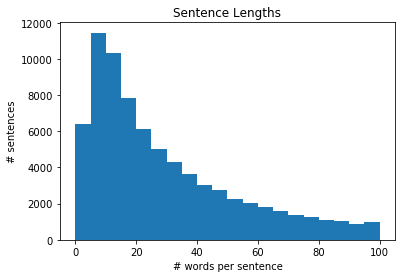

In [7]:
# Sentence Lengths
sentencelength = [len(sent) for sent in test.sentTokens]
plt.hist(sentencelength, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.title("Sentence Lengths")
plt.ylabel('# sentences')
plt.xlabel('# words per sentence')
rcParams['figure.figsize'] = 4, 4
plt.show()

In [8]:
# Word Frequencies
unique, counts = np.unique(test.allWords, return_counts=True)
wordsAndCounts = np.asarray((unique, counts)).T
wordFreq = sorted(wordsAndCounts, key=lambda x: x[1].astype(float))
ints = [[x[0].astype(str), x[1].astype(float)] for x in wordFreq]
words = [x[0] for x in ints]
counts = [x[1] for x in ints]
words = list(reversed(words))
counts = list(reversed(counts))
numwords = test.numWords
words = words[:numwords]
counts = counts[:numwords]

ytick = np.arange(0,250000,1500)

rcParams['figure.figsize'] = .2*numwords, .5*len(ytick)
indexes = np.arange(len(words))
width = .9
plt.bar(indexes, counts, width)
plt.xticks(indexes + width*.1, words, rotation='vertical')
plt.yticks(ytick)
plt.title("%d Most Frequent Words" % numwords)
plt.ylabel('# appearances')
plt.xlabel('Word')
plt.show()

<Container object of 21 artists>

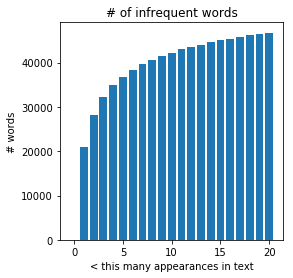

In [9]:
# of words appearing only a few times
sortedWordsAndCounts = sorted(wordsAndCounts, key=lambda x: x[1].astype(float))
sortedWordsAndCounts = [[x[0].astype(str), x[1].astype(float)] for x in sortedWordsAndCounts]

# Number of non-frequent words
freqs = np.arange(0,21,1)
lengths = []
for freq in freqs:
    temp = [x for x in sortedWordsAndCounts if x[1] <= freq]
    lengths.append(len(temp))
width = .8
indexes = np.arange(len(lengths))

rcParams['figure.figsize'] = 4, 4
plt.xlabel("< this many appearances in text")
plt.ylabel("# words")
plt.title("# of infrequent words")
plt.bar(indexes, lengths, width)